# Predict the Epic Sci-Fi Universe
# Notebook-4 (Model Evaluation)
### Perry Shyr

### This notebook covers the two best models found in the previous notebook.  I use confusion matrices and run new unseen data through my models to generate direct comparisons.  I also look at the misclassified posts from the new test data to glean differences between the logistic regression and random-forests models. 

## Load libraries

In [163]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, make_scorer, f1_score, precision_score
from sklearn.metrics import classification_report, roc_curve

np.random.seed(42)

%matplotlib inline

## Load data

#### Let's take a closer look at two of the models fitted in Notebook-3, namely the Logistic-regression and Random-forests models.  We have 'new data' collected a few days after the data used to train/test our models.  Both datasets need to be imported to perform our evaluations and new testing.

In [164]:
data        = pd.read_csv('../data/combined_no_star.csv')           #  Original dataset from both subreddits
new_test_df = pd.read_csv('../data/combined_new_test_no_star.csv')  #  New posts collected from both subreddits

#### Let's check that we are looking at the desired datasets.

In [165]:
print(data.shape)
print(data['is_trek'].sum(), 'posts are from the Star-Trek subreddit.')
data.tail()

(1829, 3)
968 posts are from the Star-Trek subreddit.


,text,title,is_trek
1824,NaN,Kate Mulgrew panel at the 2018 Trek Convention...,1
1825,How about show that the reason he never marrie...,Brilliant Idea for Trek: Picard,1
1826,NaN,The Trek Family Photo,1
1827,NaN,My inner thoughts when I heard the news,1
1828,http://i.imgur.com/Pf3HWEp.gifv\n\n/r/startrek...,When Patrick Stewart thought he was done with ...,1


In [166]:
print(new_test_df.shape)
print(new_test_df['target'].sum(), 'posts are from the Star-Trek subreddit.')
new_test_df.tail()

(441, 2)
152 posts are from the Star-Trek subreddit.


,test_titles,target
436,"""Trek V: The Final Frontier"" (1989): God only ...",1
437,Random DS9 questions,1
438,"[video] ""Matters of internal security. The age...",1
439,Starting TOS for the very first time,1
440,Jammer:Pondering Patrick Stewart’s return to t...,1


## Load sparse-matrices and models:

#### After loading the data, we can retrieve the models saved for the two models (Logistic-regression and Random-forests) as well as the model inputs from vectorizer and splits.  These model and inputs retain the hyperparameter settings used previously.

In [167]:
with open('../pickles/tfidf.pkl', 'rb') as f:                 #  Vectorized data.
    tfidf = pickle.load(f)

In [168]:
with open('../pickles/p3_xtrain_transform.pkl', 'rb') as f:   #  Training-split data in sparse matrix.
    X_train_transform = pickle.load(f)

In [169]:
with open('../pickles/p3_xtest_transform.pkl', 'rb') as f:    #  Test-split data in sparse matrix.
    X_test_transform = pickle.load(f)

In [170]:
with open('../pickles/p3_log_reg_MinDF2.pkl', 'rb') as f:     #  Logistic-regression model.     
    model_logreg = pickle.load(f)

In [171]:
with open('../pickles/p3_randomforests.pkl', 'rb') as f:      #  Random-forests model.
    model_rf = pickle.load(f)

### We split the data to give us the remaining model inputs.

In [172]:
X=data['title']
y=data['is_trek']

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state = 42)

## Evaluation

#### We can use metrics based on the confusion matrices for each model, including the calculation of accuracy/misclassification.  From this we can generate plots that convey how our model are performing for comparison purposes.

### First, for the Logistic-regression model...
#### We break out the True-Positives ('tn'), False-Negatives ('fn'), False-Positives ('fp') and True-negatives ('tn') to derive the metrics that we can display.

In [200]:
predictions_logreg = model_logreg.predict(X_test_transform)

In [201]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_logreg).ravel()
print(y_test.sum(), 'of the', len(y_test), 'test samples are from the Star-Trek subreddit.')

244 of the 458 test samples are from the Star-Trek subreddit.


In [202]:
df_cm1 = pd.DataFrame(confusion_matrix(y_test, predictions_logreg), 
                      columns=["","True Star-Trek"])

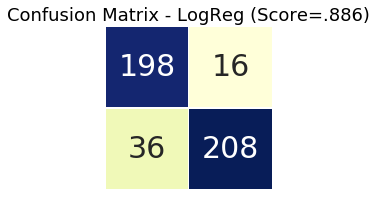

In [203]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - LogReg (Score=.886)"
plt.title(title, fontsize=18)
sns.heatmap(df_cm1, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="YlGnBu", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

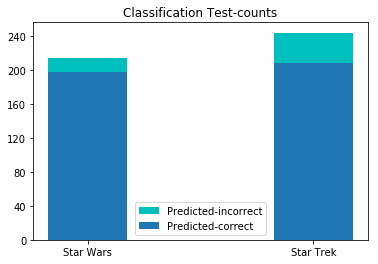

In [204]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    
width = 0.35       

p1 = plt.bar(ind, pred_right, width)
p2 = plt.bar(ind, pred_wrong, width, color='c',
             bottom=pred_right)

plt.title('Log-Reg Classification Test-counts')
plt.xticks(ind, ('Star Wars', 'Star Trek'))
plt.yticks(np.arange(0, 250, 40))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

#### From the plot above we can see that the logistic-regression model does a good job of predicting the source of the subreddit-posts.  This model does a better of classifying the Star-Wars post-titles.

### Next, for the Random-forests model ...
#### We find comparable metrics.

In [205]:
predictions_rf = model_rf.predict(X_test_transform)

In [206]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_rf).ravel()

In [207]:
df_cm2 = pd.DataFrame(confusion_matrix(y_test, predictions_rf), columns=["","True Star-Trek"])

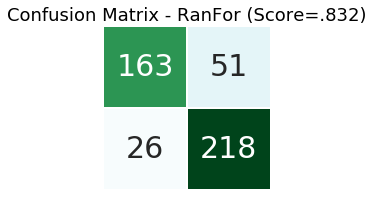

In [208]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - RanFor (Score=.832)"
plt.title(title, fontsize=18)
sns.heatmap(df_cm2, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="BuGn", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

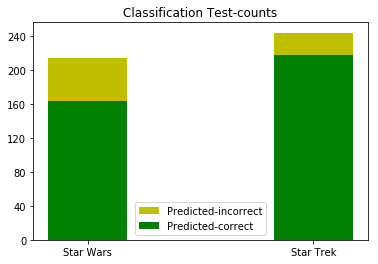

In [209]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, pred_right, width, color='g')
p2 = plt.bar(ind, pred_wrong, width, color='y',
             bottom=pred_right)

plt.title('Random-forests Classification Test-counts')
plt.xticks(ind, ('Star Wars', 'Star Trek'))
plt.yticks(np.arange(0, 250, 40))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

#### At a glance, we can see that the Random-forests classifier is more accurate for Star-Trek post-titles than the Logistic-regression model, but much less accurate for Star-Wars post-titles compared to the first model.  We might explore the feature importances for each of these models for a possible explanation.

## Features importances:
#### These importances suggest how the respective models account for certain word-features.

### For the Logistic-regression model ...
#### We look at the natural-log exponent 'loadings' and see a clear separation between the strongest features for each class.  That is, the model appears to recognize the absences of words in the positive class as predictive. 

In [210]:
df_loadings = pd.DataFrame(model_logreg.coef_, columns=tfidf.get_feature_names(), index=['is_trek_loading']).T
feat_st = df_loadings.sort_values('is_trek_loading',ascending=False).head()
feat_st

,is_trek_loading
trek,6.108114
picard,3.271791
tng,2.953499
discovery,2.691126
ds9,2.342044


In [211]:
feat_sw = df_loadings.sort_values('is_trek_loading',ascending=False).tail()
feat_sw

,is_trek_loading
vader,-1.418155
luke,-1.465894
force,-1.504496
jedi,-2.402390
wars,-4.349937


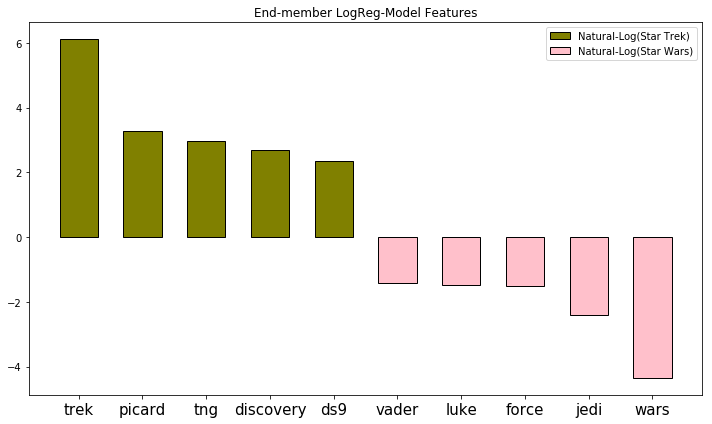

In [212]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=15)
plt.setp(labels, rotation=0)
plt.title('End-member LogReg-Model Features')
plt.bar(feat_st.index, 
        feat_st[['is_trek_loading']].T.values[0], 
        alpha=1, align='center', width=-.6, ec='k', color='olive')
plt.bar(feat_sw.index, 
        feat_sw[['is_trek_loading']].T.values[0], 
        alpha=1, align='center', width=.6, ec='k', color='pink')
plt.legend(['Natural-Log(Star Trek)','Natural-Log(Star Wars)'])
plt.tight_layout();

### For the Random-forests model ...
#### There is a relatively stronger 'signal' from the positive class (r/startrek post-titles), which happens to also be the majority class.  On the absolute scale of Random-forests importances, only two of the top-10 word-features ("wars" and "jedi") ranked by loadings, comes from the negative/minority class.  This might be the trade-off for a classifier that is not overfit (has low-variance), but more bias.

In [213]:
df_loads = pd.DataFrame(model_rf.feature_importances_.reshape(model_rf.feature_importances_.shape[0],-1).T, 
                           columns=tfidf.get_feature_names(), index=['is_trek_loading']).T
df_loads = df_loads.sort_values('is_trek_loading',ascending=False).head(10)
df_loads

,is_trek_loading
trek,0.103428
wars,0.052620
picard,0.031138
tng,0.026870
discovery,0.023037
jedi,0.019217
ds9,0.016794
enterprise,0.015647
series,0.014122
voyager,0.012567


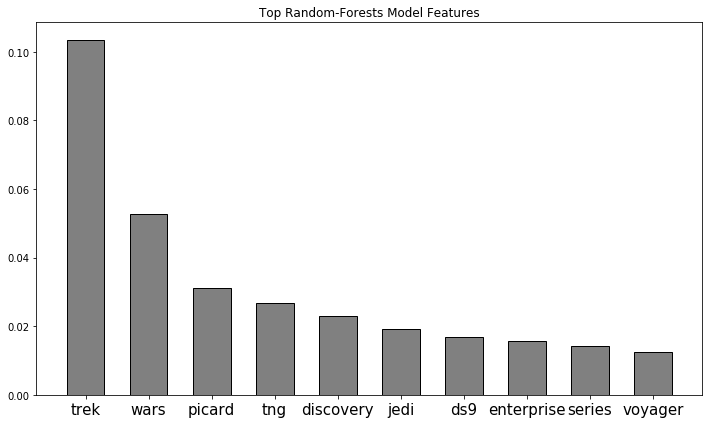

In [214]:
plt.figure(figsize=(10,6))
locs, labels = plt.xticks(fontsize=15)
plt.setp(labels, rotation=0)
plt.title('Top Random-Forests Model Features')
plt.bar(df_loads.index, 
        df_loads[['is_trek_loading']].T.values[0], 
        alpha=1, align='center', width=.6, ec='k', color='gray')
plt.tight_layout();

### Now, let's see how the models perform on separate and unique data gathered from a completely different period.

## Prediction on New Data:

### 441 post-titles collected on Sep-06 included 289 Star-wars and 152 Star-Trek unique post-titles, not found in the training data.  This is almost too unbalanced (about 65% to 35%) a dataset to consider testing with, but let's go ahead a evaluate the two models of interest against it.

### For Logistic regression...

In [215]:
X_new = new_test_df['test_titles']
y_new=new_test_df['target']

In [216]:
X_new_transform = tfidf.transform(X_new)

In [217]:
model_logreg.score(X_new_transform, y_new)

0.8934240362811792

#### We see the test score as comparably high, which is an encouraging sign.

In [218]:
predictions_logreg_new = model_logreg.predict(X_new_transform)

In [193]:
probas_logreg_new = model_logreg.predict_proba(X_new_transform)

#### Here, we flatten the confusion-matrix and present the precision and recall (sensitivity) metrics.  The average scores as shown on this classification report below, are quite consistent.  We do see lower (0.83 and 0.85) metrics results for the positive/minority class, likely due to the inbalance.

In [219]:
tn, fp, fn, tp = confusion_matrix(y_new, predictions_logreg_new).ravel()
print(classification_report(y_new, predictions_logreg_new))

             precision    recall  f1-score   support

          0       0.93      0.90      0.92       289
          1       0.83      0.88      0.85       152

avg / total       0.90      0.89      0.89       441



In [220]:
df_cm3 = pd.DataFrame(confusion_matrix(y_new, predictions_logreg_new), columns=["","True Star-Trek"])

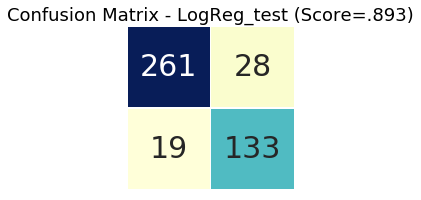

In [221]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - LogReg_test (Score=.893)"
plt.title(title, fontsize=18)
sns.heatmap(df_cm3, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="YlGnBu", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

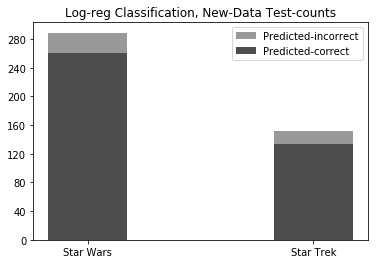

In [222]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    
width = 0.35       

p1 = plt.bar(ind, pred_right, width, color='.3')
p2 = plt.bar(ind, pred_wrong, width, color='.6',
             bottom=pred_right)

plt.title('Log-reg Classification, New-Data Test-counts')
plt.xticks(ind, ('Star Wars', 'Star Trek'))
plt.yticks(np.arange(0, 300, 40))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

In [248]:
print('Logistic-regression Model with New Data:')
print('')
print('Ct|false-Prediction|   Confidence  | Post-title')
print('')
ct_logreg=0
for i in range(len(X_new)):
    if list(predictions_logreg_new)[i] != y_new[i]:
        ct_logreg += 1
        if list(predictions_logreg_new)[i] == 0:
            print(ct_logreg, 'false-Wars',probas_logreg_new[i],X_new[i])
        else:
            print(ct_logreg, 'false-Trek',probas_logreg_new[i], X_new[i])

Logistic-regression Model with New Data:

Ct|false-Prediction|   Confidence  | Post-title

1 false-Trek [0.48450756 0.51549244] Fulfill your destiny
2 false-Trek [0.38189911 0.61810089] Any good books set in the OT without any of the main characters
3 false-Trek [0.43215753 0.56784247] Hailfire droid vs AT-AT: Which would win?
4 false-Trek [0.23231479 0.76768521] Is there anyone that knows the name of this ship?
5 false-Trek [0.31593039 0.68406961] Episodes I-VI Bonus Features
6 false-Trek [0.37713163 0.62286837] Was watching Evolution on Amazon when I saw a trivia popup about David Duchovny. Big mistake David.
7 false-Trek [0.44935641 0.55064359] Box set for episodes 7-9? (See text) (Movies)
8 false-Trek [0.43452567 0.56547433] I was rewatching season 1 of Rebels and a line from Tarken stood out to me
9 false-Trek [0.48468879 0.51531121] This label maker knows what it’s doing
10 false-Trek [0.39555927 0.60444073] Are there any intelligent aquatic species that can't breathe on land?
11

### Misclassified posts (about 10.7% on average for logistic-regression):
#### Let us look at how confidently this model incorrectly predicted the subreddit source.  The highest confidences (greater than 69% or less than 31%) for wrong predictions are listed below:

| Log-Reg False-Predictions | Unseen Post-titles |
| --- | --- |
| False-StarTrek | Is there anyone that knows the name of this ship? |
| False-StarTrek | Can lightning be summoned in space? |
| False-StarWars | How did you fall in love? |
| False-StarWars | What are your favorite Enterprises? |
#### The most confident errors contained "ship" and "love" features that are understandably ambiguous, but clearly the word "enterprise" was not trained well by my model.
#### For all the other false-positives/-negatives, the logistic-regression model was not relatively confident in its prediction.  This might be fixed my training on a more extensive set of 2,000 or 3,000 post-titles from each subreddit.

### Can word frequency in model training explain the false predictions?
#### We can use the Count-Vectorized data to help answer this question.

In [224]:
df_cvec = pd.read_csv('../data/cvec.csv')

In [225]:
def get_posts_for_feat(df, word):
    count =[df.iloc[:,i].sum() for i in range(len(df.T)) if df.columns[i] == word]
    col = [i for i in range(len(df.T)) if df.columns[i] == word]
    rows = []
    for i in range(len(df)):
        if df.iloc[i,col[0]]==1:
            rows.append(i) 
    return count, rows

In [226]:
my_word = 'ship'
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])
my_word = 'lightning'
print('')
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])
my_word = 'space'
print('')
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])
my_word = 'fall'
print('')
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])
my_word = 'love'
print('')
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])
my_word = 'favorite'
print('')
print('The word "', my_word, '" is found', get_posts_for_feat(df_cvec,my_word)[0],
      'times, on rows', get_posts_for_feat(df_cvec,my_word)[1])

The word " ship " is found [18] times, on rows [590, 871, 889, 1021, 1064, 1137, 1178, 1380, 1407, 1447, 1482, 1537, 1655, 1685, 1701, 1715, 1741, 1804]

The word " lightning " is found [1] times, on rows [220]

The word " space " is found [35] times, on rows [595, 765, 815, 853, 895, 909, 915, 936, 942, 954, 979, 992, 1004, 1013, 1073, 1100, 1146, 1152, 1183, 1192, 1200, 1280, 1305, 1329, 1415, 1423, 1525, 1544, 1578, 1586, 1614, 1727, 1757, 1762, 1800]

The word " fall " is found [2] times, on rows [1575, 1721]

The word " love " is found [27] times, on rows [8, 141, 310, 409, 431, 444, 507, 515, 617, 634, 641, 693, 726, 728, 836, 852, 1001, 1194, 1294, 1461, 1486, 1504, 1532, 1705, 1715, 1721, 1803]

The word " favorite " is found [28] times, on rows [10, 30, 120, 148, 218, 250, 296, 311, 318, 343, 429, 493, 618, 642, 657, 729, 750, 787, 901, 953, 954, 1069, 1125, 1155, 1426, 1483, 1712, 1752]


#### Looking at the words "ship," "lightning" and "space," I found that "ship" and "space" were found more frqeuently in the training data for Star-Trek post-titles.  (I know this from the row numbers; rows 1-858 were from 'r/StarWars.')  This explains why the training would lead these to be classified incorrectly.

#### A similar explanation might explain the wildly-incorrect prediction on the third problem post-title, where "love" is found more frequently in Star-Wars post-titles in training.  For the last problem post-title it appears that "favorite" might be the explanation for the confusion leading to a prediction of a Star-Wars post-title, because it clearly hasn't learned of the significance of "enterprise".
#### Maybe lemmatizing or stemming would have solved this problem.

### For testing of my Random-forests model on separate/unique unseen data from a later period ...
#### The test score was about 5% lower compared to the earlier test.

In [227]:
model_rf.score(X_new_transform, y_new)

0.81859410430839

In [228]:
predictions_rf_new = model_rf.predict(X_new_transform)

In [229]:
probas_rf_new = model_rf.predict_proba(X_new_transform)

In [230]:
tn, fp, fn, tp = confusion_matrix(y_new, predictions_rf_new).ravel()
print(classification_report(y_new, predictions_rf_new))

             precision    recall  f1-score   support

          0       0.93      0.79      0.85       289
          1       0.68      0.88      0.77       152

avg / total       0.84      0.82      0.82       441



#### The average metric scores reflect the lower predictive results.

In [231]:
df_cm4 = pd.DataFrame(confusion_matrix(y_new, predictions_rf_new), columns=["","True Star-Trek"])

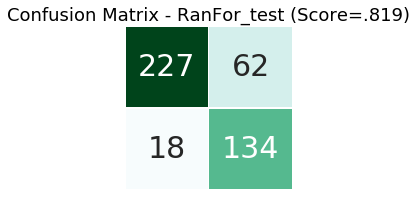

In [232]:
fig, ax = plt.subplots(figsize=(3,3))
title= "Confusion Matrix - RanFor_test (Score=.819)"
plt.title(title, fontsize=18)
sns.heatmap(df_cm4, 
            annot=True, 
            annot_kws={"size": 30}, 
            linewidths=.5, 
            fmt="g", 
            cmap="BuGn", 
            cbar=False,
            xticklabels=False,
            yticklabels=False)

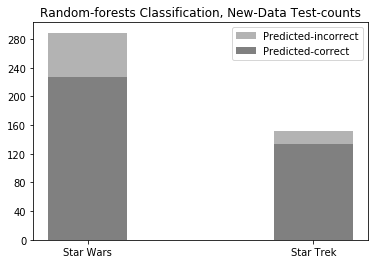

In [233]:
N = 2
pred_right = (tn, tp)
pred_wrong = (fp, fn)
ind = np.arange(N)    
width = 0.35       

p1 = plt.bar(ind, pred_right, width, color='0.5')
p2 = plt.bar(ind, pred_wrong, width, color='0.7',
             bottom=pred_right)

plt.title('Random-forests Classification, New-Data Test-counts')
plt.xticks(ind, ('Star Wars', 'Star Trek'))
plt.yticks(np.arange(0, 300, 40))
plt.legend((p2[0], p1[0]), ('Predicted-incorrect', 'Predicted-correct'))

#### Compared to the logistic-regression predictions on the new-test data directly above, there was slightly better accuracy for the positive-minority class and much worse accuracy for the negative/majority class, surprisingly enough.  It seems as though the balance of the classes, or lack thereof, is not a factor in the test of the newer data.  

#### Again, the logistic-regressor learned the uniqueness of the Star-Wars/Star-Trek language well, while the random-forests ensemble approach learned the positive class based on the relative strength of the feature importances.

### Misclassified posts (about 18% on average for random-forests):
#### We can look at how confidently this model incorrectly predicted the subreddit source, as we did above.  The highest confidences (greater than 69% or less than 31%) for wrong predictions are listed below:

| Random-forests False-Predictions | Unseen Post-titles |
| --- | --- |
| False-StarTrek | Any good books set in the OT without any of the main characters |
| False-StarTrek | Hailfire droid vs AT-AT: Which would win? |
| False-StarTrek | Is there anyone that knows the name of this ship? |
| False-StarTrek | Episodes I-VI Bonus Features |
| False-StarTrek | Box set for episodes 7-9? (See text) (Movies) |
| False-StarTrek | I was rewatching season 1 of Rebels and a line from Tarken stood out to me |
| False-StarTrek | Are there any intelligent aquatic species that can't breathe on land? |
| False-StarTrek | 1000 Storm Troopers vs 2000 Nazi Zombies - Ultimate epic simulator |
| False-StarTrek | Can lightning be summoned in space? |
| False-StarTrek | All the hate for BFII aside - I REALLY enjoyed.. |
| False-StarTrek |  Let’s talk cross fire. Why isn’t it really an issue in any of the live action or animated series? |
| False-StarTrek | Need a pepakura file! |
| False-StarWars | How did you fall in love? |
| False-StarWars | Is there something that a show or movie did wrong, but you don't think could've ever been done right? |
| False-StarWars | Taking Memory Beta out of context is fun |
| False-StarWars | Here's a thought: what would they keep in their pockets? (If they had them?) |
| False-StarWars | What are your favorite Enterprises? |
| False-StarWars | Anyone for a good old sing-song? |
| False-StarWars | [video] "Matters of internal security. The age-old cry of the Oppressor" |
#### There were many more confident errors including the errors made by the logistic-regression model, but the level of confidence was markedly higher.  What is interesting is that the missclassification of the four post-titles by logistic-regression model, were also wildly misclassified by the random-forests model.

In [249]:
print('Random-forests Model with New Data:')
print('')
print('Ct|false-Prediction|   Confidence  | Post-title')
print('')
ct_rf=0
for i in range(len(X_new)):
    if list(predictions_rf_new)[i] != y_new[i]:
        ct_rf += 1
        if list(predictions_rf_new)[i] == 0:
            print(ct_rf, 'false-Wars',probas_rf_new[i],X_new[i])
        else:
            print(ct_rf, 'false-Trek',probas_rf_new[i],X_new[i])

Random-forests Model with New Data:

Ct|false-Prediction|   Confidence  | Post-title

1 false-Trek [0.46524996 0.53475004] Fulfill your destiny
2 false-Trek [0.41775494 0.58224506] Sweet cufflinks I found at Fan Expo
3 false-Trek [0.46524996 0.53475004] 🤦🏼‍♂️
4 false-Trek [0.13777034 0.86222966] Any good books set in the OT without any of the main characters
5 false-Trek [0.19741625 0.80258375] Hailfire droid vs AT-AT: Which would win?
6 false-Trek [0.44113663 0.55886337] Amazing looking shoretrooper at Dragon con in Atlanta.
7 false-Trek [0.46524996 0.53475004] Jyn Erso, by Tomas Overbai
8 false-Trek [0.47527496 0.52472504] Jeremy Bulloch Grabs Leia?
9 false-Trek [0.46524996 0.53475004] Grandma Tarkin
10 false-Trek [0.46524996 0.53475004] You have to believe...
11 false-Trek [0.48215472 0.51784528] Was the prequel government a theocracy?
12 false-Trek [0.08374025 0.91625975] Is there anyone that knows the name of this ship?
13 false-Trek [0.46524996 0.53475004] LoL
14 false-Trek [0.06

#### There were many more wildly incorrect Star-Trek predictions.  The model was trained to focus better on Star-Trek post-titles, so this might explain the false-positives.

# Conclusion

### Based on the lower misclassification rate and higher accuracy, the logistic-regression model appears to be the superior classifier.  The logistic-regression model also seems to slightly more accurate in generalizing Star-Wars posts, while the random-forests model is more accurate for predicting Star-Trek posts.

### It makes sense that training with more data would only improve the accuracy of each of the models.  There were wildly-confident misclassifications where lemmatizing or stemming would have been effective.  The reason for the generally high predictability of the model may lie in the rich distinctiveness of the language built in each franchise.

### Our best models beat our baseline model without a doubt.  They provide a means to identify 'r/startrek' post-titles and a more tempered Sci-Fi universe with compelling stories as well as balanced character diversity.

# Executive Summary

###  The Social-Justice Warriors are taking a bashing among fans of the post-Lucas Star-Wars-Extended-Universe.  On the other hand, all is relatively quiet on the Star-Trek-Extended-Universe front.  The average Sci-Fi enthusiast would do well to avoid the toxic tension of the former fandom in the media.

### There’s a huge bummer associated with encountering a spoiler.  Whether it be in sports of movies, wouldn’t it be great to avoid that algorithmicly?  We need a reliable way to identify if a post or media article is talking about Star Wars and what are the most important words to look for to make that identification.

### My model can generalize new posts for the source and thereby the expected level of tameness in the contents.  Trained from the titles of about 900 posts, one can be almost 90% sure which flavor of the galactic genres one is about to read.

### There are distinct collections of words that make the separation between the two subjects possible, such that only 10-15% of posts are truly ambiguous.  This can be done using one for two classifier models.

### Don’t wait.  Subscribe to our filtering guide today and save yourself the aggravation of reading another SJW-battering comment.  Get out of the Dark Side, once and for all.

## Thank you!